In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports Libraries and Tools

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array

# Directories

In [4]:
# Directories
train_dir = '/content/drive/MyDrive/Dataset/Brain_tumor_dataset/Training'
test_dir = '/content/drive/MyDrive/Dataset/Brain_tumor_dataset/Testing'

# Data generators with augmentation

In [23]:
# Parameters
IMAGE_SIZE = 224
batch_size = 20
epochs = 10

# Data generators with augmentation
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.8, 1.2),
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

val_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    shuffle=True

)
datagen_test = ImageDataGenerator(rescale=1./255)


test_generator = datagen_test.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=1,
    class_mode='sparse',
    shuffle=False
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# Show sample images

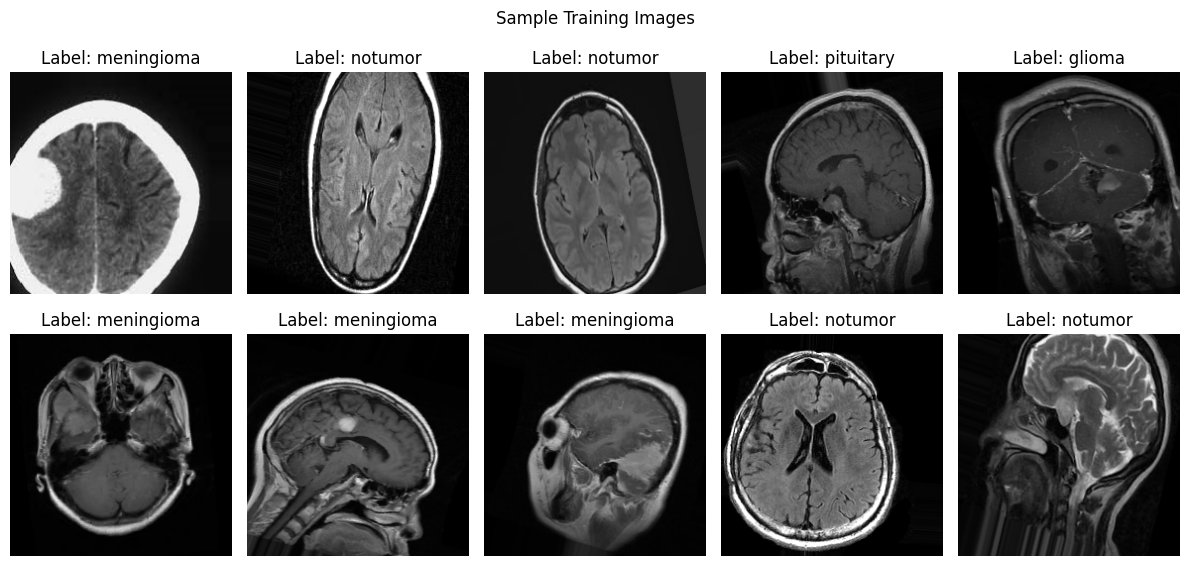

In [14]:
# Show sample images from training data
class_indices = {v: k for k, v in train_generator.class_indices.items()}
sample_images, sample_labels = next(train_generator)
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_images[i])
    class_name = class_indices[int(sample_labels[i])]
    plt.title(f"Label: {class_name}")
    plt.axis('off')
plt.suptitle('Sample Training Images')
plt.tight_layout()
plt.show()

# Model setup

In [15]:
# Model setup
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-6:]:
    layer.trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(train_generator.num_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Print model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,596 (68.38 MB)

 Trainable params: 12,651,140 (48.26 MB)

 Non-trainable params: 5,275,456 (20.12 MB)

#Model Train

In [16]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

# Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=callbacks
)

Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.7285 - sparse_categorical_accuracy: 0.6986

229/229 ━━━━━━━━━━━━━━━━━━━━ 1012s 4s/step - loss: 0.7276 - sparse_categorical_accuracy: 0.6990 - val_loss: 0.6185 - val_sparse_categorical_accuracy: 0.7844
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - loss: 0.2849 - sparse_categorical_accuracy: 0.8991

229/229 ━━━━━━━━━━━━━━━━━━━━ 138s 464ms/step - loss: 0.2849 - sparse_categorical_accuracy: 0.8991 - val_loss: 0.4264 - val_sparse_categorical_accuracy: 0.8703
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - loss: 0.2032 - sparse_categorical_accuracy: 0.9276

229/229 ━━━━━━━━━━━━━━━━━━━━ 143s 467ms/step - loss: 0.2033 - sparse_categorical_accuracy: 0.9276 - val_loss: 0.4129 - val_sparse_categorical_accuracy: 0.8554
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - loss: 0.1860 - sparse_categorical_accuracy: 0.9300

229/229 ━━━━━━━━━━━━━━━━━━━━ 141s 462ms/step - loss: 0.1859 - sparse_categorical_accuracy: 0.9301 - val_loss: 0.3748 - val_sparse_categorical_accuracy: 0.8729
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 164s 559ms/step - loss: 0.1518 - sparse_categorical_accuracy: 0.9436 - val_loss: 0.3829 - val_sparse_categorical_accuracy: 0.8904
Epoch 6/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - loss: 0.1160 - sparse_categorical_accuracy: 0.9585

229/229 ━━━━━━━━━━━━━━━━━━━━ 121s 466ms/step - loss: 0.1160 - sparse_categorical_accuracy: 0.9585 - val_loss: 0.3252 - val_sparse_categorical_accuracy: 0.8975
Epoch 7/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - loss: 0.1132 - sparse_categorical_accuracy: 0.9640

229/229 ━━━━━━━━━━━━━━━━━━━━ 113s 491ms/step - loss: 0.1132 - sparse_categorical_accuracy: 0.9640 - val_loss: 0.3120 - val_sparse_categorical_accuracy: 0.9229
Epoch 8/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 113s 491ms/step - loss: 0.0634 - sparse_categorical_accuracy: 0.9764 - val_loss: 0.4432 - val_sparse_categorical_accuracy: 0.8755
Epoch 9/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - loss: 0.0790 - sparse_categorical_accuracy: 0.9748

229/229 ━━━━━━━━━━━━━━━━━━━━ 138s 475ms/step - loss: 0.0791 - sparse_categorical_accuracy: 0.9748 - val_loss: 0.2826 - val_sparse_categorical_accuracy: 0.9264
Epoch 10/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 146s 493ms/step - loss: 0.0569 - sparse_categorical_accuracy: 0.9793 - val_loss: 0.3414 - val_sparse_categorical_accuracy: 0.9080


# Plotting training & validation accuracy/loss

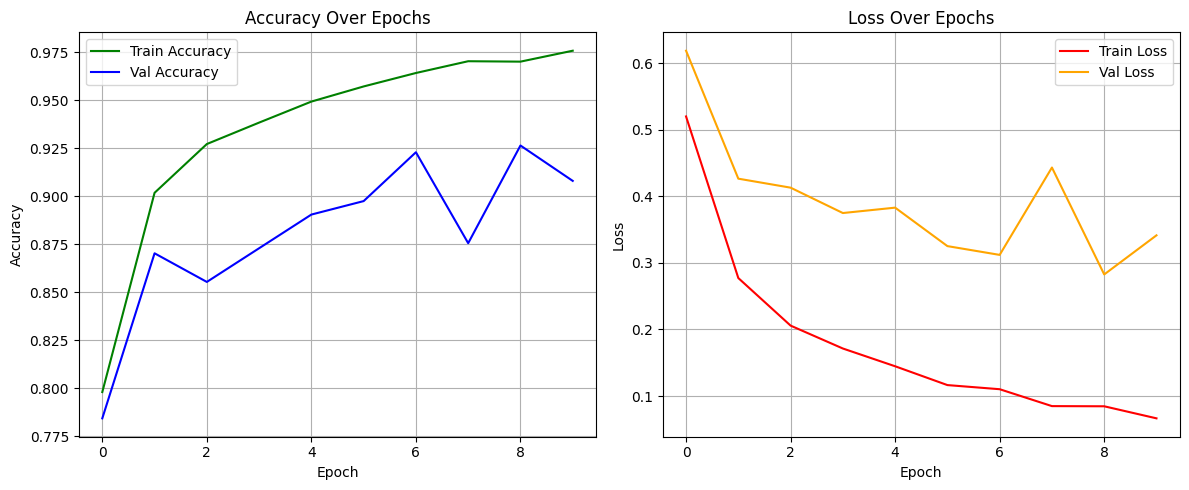

In [17]:
# Plotting training & validation accuracy/loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], 'g-', label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], 'b-', label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'r-', label='Train Loss')
plt.plot(history.history['val_loss'], 'orange', label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation

In [24]:
# Evaluation
model.save("brain_tumor_vgg16_model.h5")
model = load_model("brain_tumor_vgg16_model.h5")

pred_probs = model.predict(test_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1311/1311 ━━━━━━━━━━━━━━━━━━━━ 250s 190ms/step


# Classification Report

In [25]:
# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

Classification Report:

              precision    recall  f1-score   support

      glioma       0.97      0.94      0.95       300
  meningioma       0.96      0.92      0.94       306
     notumor       0.99      0.98      0.98       405
   pituitary       0.91      0.99      0.95       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



# Confusion Matrix

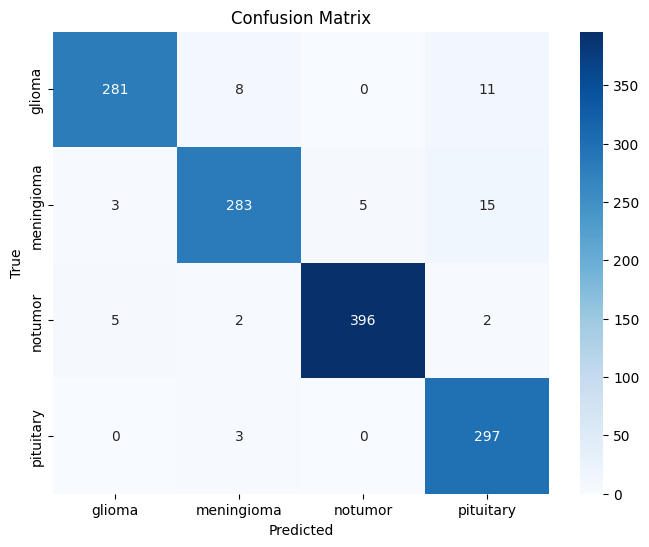

In [26]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# ROC Curve

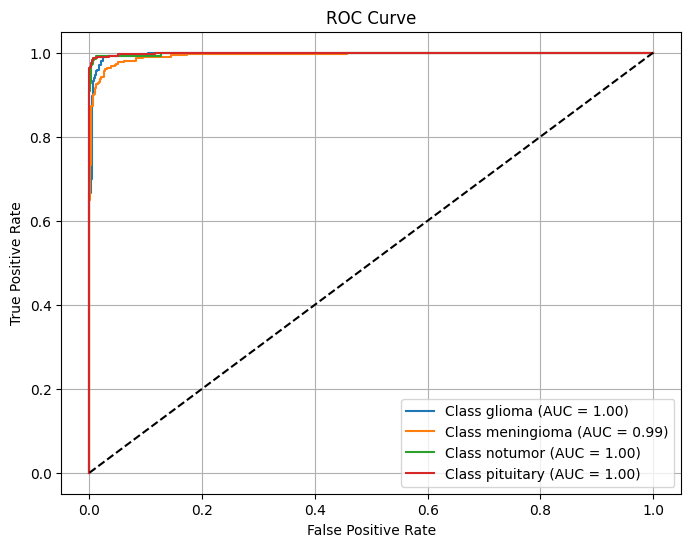

In [27]:
# ROC Curve
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(test_generator.class_indices)
y_true_bin = np.zeros((len(y_true), n_classes))
y_true_bin[np.arange(len(y_true)), y_true] = 1

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_indices[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [28]:
# Predict Unknown Image
def detect_and_display(img_path, model, image_size=224):
    class_labels = list(test_generator.class_indices.keys())
    try:
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step


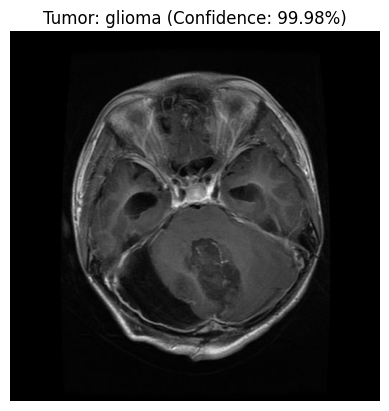

In [30]:
# Example usage
image_path = '/content/drive/MyDrive/Dataset/Brain_tumor_dataset/Testing/glioma/Te-glTr_0000.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


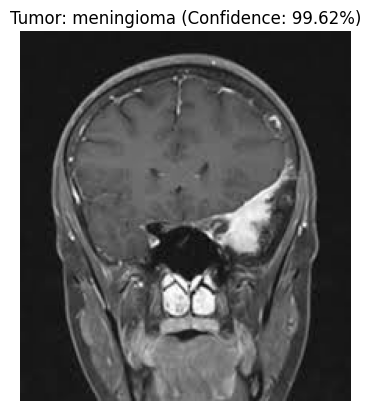

In [32]:
# Example usage
image_path = '/content/drive/MyDrive/Dataset/Brain_tumor_dataset/Testing/meningioma/Te-meTr_0003.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


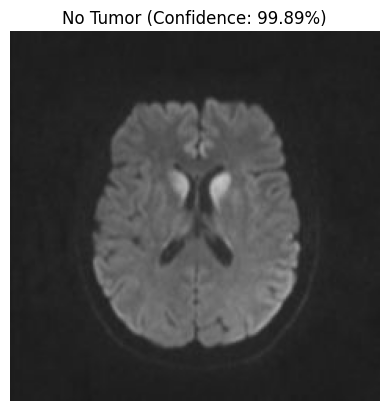

In [38]:
# Example usage
image_path = '/content/drive/MyDrive/Dataset/Brain_tumor_dataset/Testing/notumor/Te-noTr_0007.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


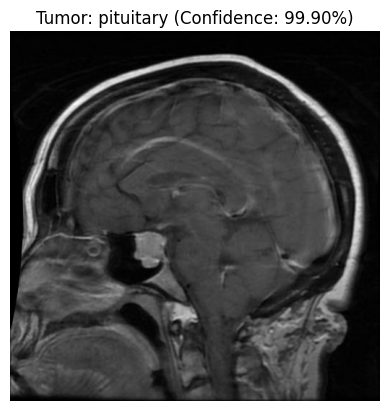

In [36]:
# Example usage
image_path = '/content/drive/MyDrive/Dataset/Brain_tumor_dataset/Testing/pituitary/Te-piTr_0005.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)